# Attention analysis

## loading multiple attention files

In [42]:
from glob import glob
import os

bases = glob('outputs/exp5*')
# bases = glob('outputs/exp4*')
# bases += glob('outputs/exp5*')
# bases += glob('outputs/exp6*')

exp_files = [glob(os.path.join(b, '*_attentions.pkl')) for b in bases]
print([(b, len(e)) for b, e in zip(bases, exp_files)])

json_files = [[p.replace('_attentions.pkl', '.json') for p in files] for files in exp_files]

exp_files[-1][:3], json_files[-1][:3]

[('outputs/exp5_13b_c5_hf_partial', 300), ('outputs/exp5_13b_c3_hl_partial', 300), ('outputs/exp5_13b_c3_hf_partial', 300), ('outputs/exp5_13b_c1_hl_partial', 300), ('outputs/exp5_13b_full', 300), ('outputs/exp5_13b_c1_hf_partial', 300), ('outputs/exp5_13b_c5_hl_partial', 300)]


(['outputs/exp5_13b_c5_hl_partial/3519_attentions.pkl',
  'outputs/exp5_13b_c5_hl_partial/1767_attentions.pkl',
  'outputs/exp5_13b_c5_hl_partial/156_attentions.pkl'],
 ['outputs/exp5_13b_c5_hl_partial/3519.json',
  'outputs/exp5_13b_c5_hl_partial/1767.json',
  'outputs/exp5_13b_c5_hl_partial/156.json'])

## getting attention on strategy tokens

In [45]:
from analyze_attention_weights import get_average_attention_over_sequence
import pickle
from transformers import AutoTokenizer
from tqdm import tqdm
from typing import Dict, List

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-13b-chat-hf')

def get_attention_per_strategy(files, exp_name) -> List[Dict]:
    data = []
    filtered_files = []
    for file in files:
        try:
            with open(file, 'rb') as f:
                data.append(pickle.load(f))
                filtered_files.append(file)
        except Exception as e:
            print(f"couldn't load {file}.")
            raise e

    res = []
    for example, p in tqdm(zip(data, filtered_files)):
        if example is None:
            continue
        for strategy, (tokens, attentions) in example.items():
            strategy_str = f'"{strategy}"'
            attn = get_average_attention_over_sequence(attentions, tokens, sequence=strategy_str, tokenizer=tokenizer)
            res.append({
                'strategy': strategy,
                'strategy_attn': attn,
                'method': exp_name,
                'path': p
            })
            
    return res



attns = [get_attention_per_strategy(files, exp_name) for files, exp_name in zip(exp_files, [b.split('/')[-1] for b in bases])]
    

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

300it [00:01, 190.71it/s]
300it [00:01, 163.41it/s]
300it [00:01, 187.48it/s]
300it [00:01, 192.77it/s]
300it [00:01, 220.21it/s]
300it [00:01, 243.46it/s]
300it [00:01, 183.95it/s]


In [29]:
import re

def get_attention_per_strategy_and_description(files, exp_name) -> List[Dict]:
    data = []
    filtered_files = []
    for file in files:
        with open(file, 'rb') as f:
            data.append(pickle.load(f))
            filtered_files.append(file)

    res = []
    for example, p in tqdm(zip(data, filtered_files)):
        if example is None:
            continue
        for strategy, (tokens, attentions) in example.items():
            decoded_prompt = tokenizer.decode(tokens, skip_special_tokens=False)
            match = re.findall(f'one turn using \"{strategy}\".+{strategy} strategy\.', decoded_prompt)
            
            if len(match) == 0 or len(match) > 1:
                print("WARNING: zero or multiple matches. continuing..")
                continue
            attn = get_average_attention_over_sequence(attentions, tokens, sequence=match[0], tokenizer=tokenizer)
            res.append({
                'strategy': strategy,
                'strategy_desc_attn': attn,
                'method': exp_name,
                'path': p
            })
            
    return res


attns2 = [get_attention_per_strategy_and_description(files, exp_name) for files, exp_name in zip(exp_files, [b.split('/')[-1] for b in bases])]

300it [00:01, 259.23it/s]
300it [00:01, 190.92it/s]
300it [00:01, 262.06it/s]
300it [00:01, 196.04it/s]
300it [00:01, 189.60it/s]
300it [00:01, 197.24it/s]
300it [00:01, 192.92it/s]
300it [00:01, 259.65it/s]
300it [00:01, 216.92it/s]
300it [00:01, 240.61it/s]
300it [00:01, 227.88it/s]
300it [00:01, 259.70it/s]
300it [00:01, 229.07it/s]
300it [00:01, 232.34it/s]
100it [00:00, 280.58it/s]
100it [00:00, 251.04it/s]
100it [00:00, 196.09it/s]
100it [00:00, 269.95it/s]
100it [00:00, 224.87it/s]
100it [00:00, 203.65it/s]
100it [00:00, 198.04it/s]


## visualize sra for different model sizes

In [46]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

all_attns = [a for attn in attns2 for a in attn]

df = pd.DataFrame(all_attns)

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['method'].apply(add_template_type)
df['model size'] = df['method'].apply(add_model_size)
plt.figure(figsize=(15,6))
sns.barplot(df, x='model size', y='strategy_desc_attn', hue='template type')
plt.xticks(rotation=43)
plt.ylabel('SRA')
plt.show()


NameError: name 'attns2' is not defined

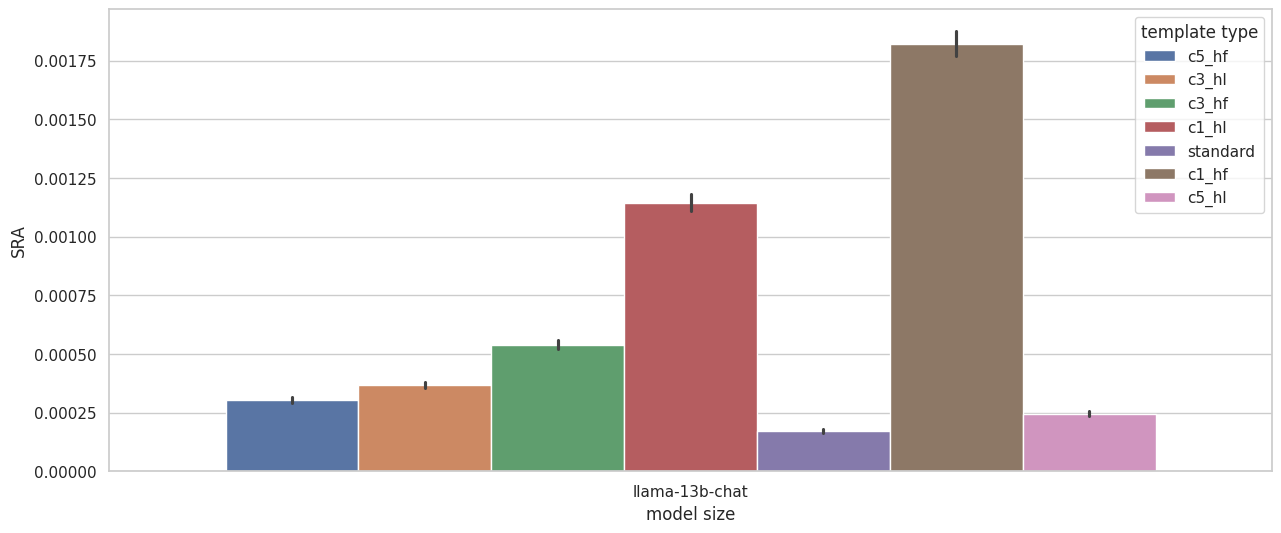

In [47]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

all_attns = [a for attn in attns for a in attn]

df = pd.DataFrame(all_attns)

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['method'].apply(add_template_type)
df['model size'] = df['method'].apply(add_model_size)
plt.figure(figsize=(15,6))
sns.barplot(df, x='model size', y='strategy_attn', hue='template type')
plt.ylabel('SRA')

plt.show()


/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

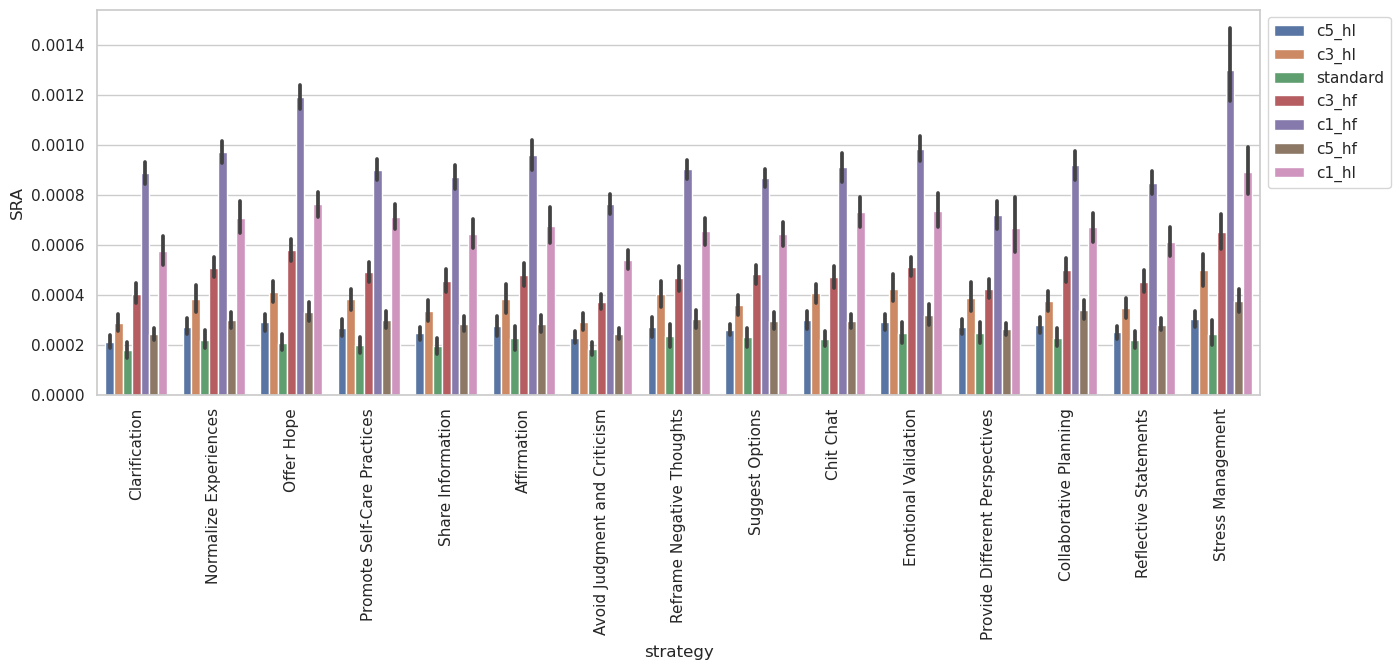

In [9]:
import numpy as np
import seaborn as sns
import pandas as pd

all_attns = [a for attn in attns for a in attn]
df = pd.DataFrame(all_attns)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
df['template type'] = df['method'].apply(add_template_type)
sns.barplot(df[df['method'].str.contains('exp6')], x='strategy', y='strategy_attn', hue='template type')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('SRA')
plt.show()


## measuring attention vs number of utterances in history

### get length of inputs per attention outputs

In [48]:
import json 

attn_lens = []
all_attns = [a for attn in attns for a in attn]

for example in tqdm(all_attns):
    json_path = example['path'].replace('_attentions.pkl', '.json')
    
    with open(json_path, 'r') as f:
        json_d = json.load(f)
    n_turns = len(json_d['dialog'])
    d = example.copy()
    d['n_turns'] = n_turns
    attn_lens.append(d)

attn_lens[-1]

df = pd.DataFrame(attn_lens)
df['template type'] = df['method'].apply(add_template_type)
df['model name'] = df['method'].apply(add_model_size)

100%|██████████████████████████████████████████████████████████████████████████| 9464/9464 [00:00<00:00, 13766.08it/s]


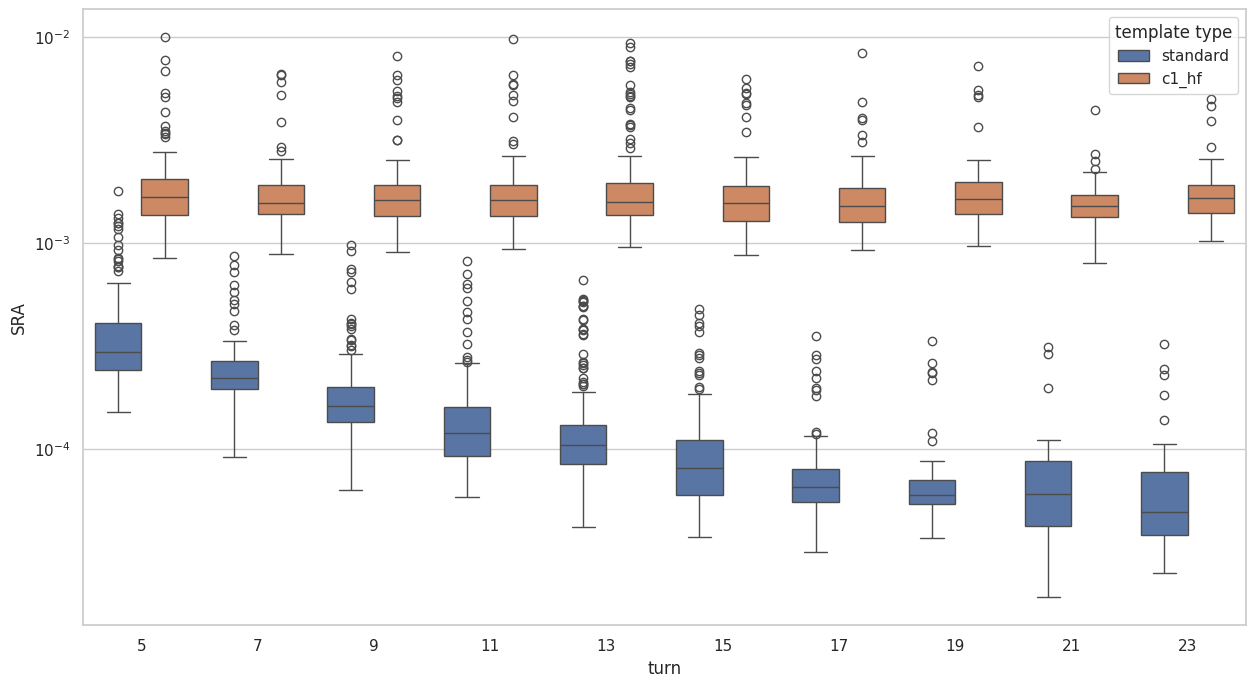

In [54]:

import matplotlib.pyplot as plt
df['template type'] = df['method'].apply(add_template_type)
df['model size'] = df['method'].apply(add_model_size)

plt.figure(figsize=(15,8))
sns.boxplot(df[(df['template type'] == 'c1_hf') | (df['template type'] == 'standard')], x='n_turns', y='strategy_attn', hue='template type')
plt.yscale('log')
plt.ylabel('SRA')
plt.xlabel('turn')
plt.show()


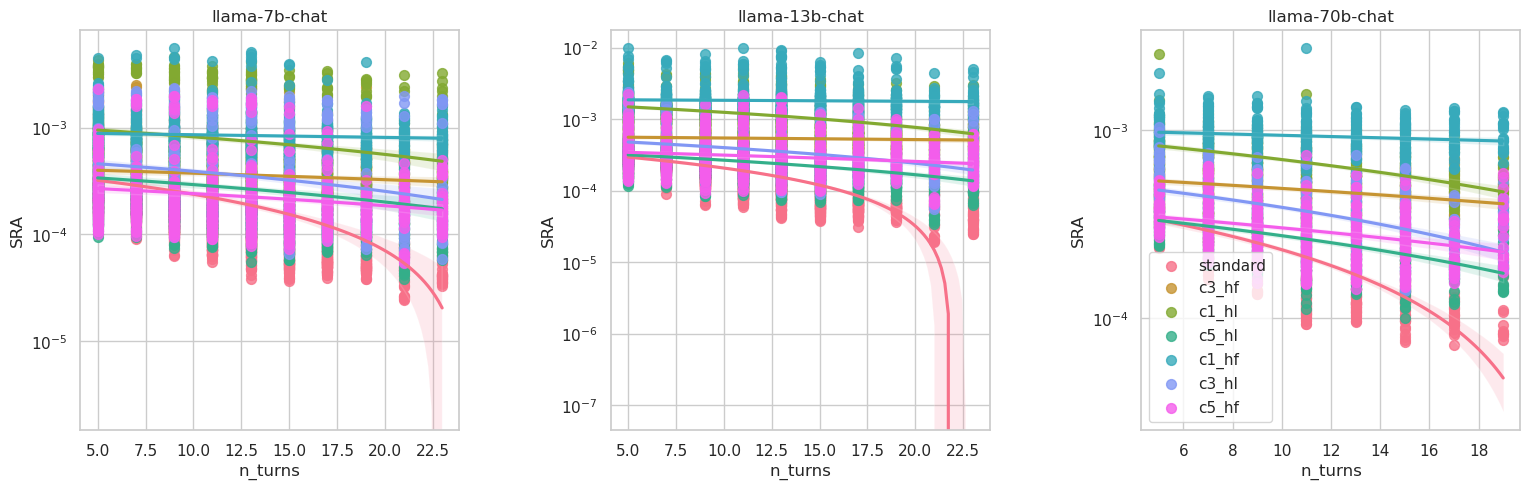

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Color palette
template_types = list(df['template type'].unique())
palette = sns.color_palette('husl', len(template_types))

model_names = list(df['model name'].unique())
for ax, model_name in zip(axs, model_names):
    cur_df = df[df['model name'] == model_name]
    ax.set_title(model_name)
    # Iterate over each group to plot
    for i, group in enumerate(template_types):
        subset = cur_df[cur_df['template type'] == group]
        sns.regplot(x='n_turns', y='strategy_attn', data=subset, ax=ax, label=group, color=palette[i], scatter_kws={'s': 50})
    ax.set_ylabel('SRA')
    ax.set_yscale('log')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.legend()
plt.show()


In [ ]:

plt.figure(figsize=(15,8))

sns.boxplot(df[(df['method']=='exp4_7b_full')], x='n_turns', y='strategy_desc_attn')
plt.xlabel('turn')
plt.ylabel('SRA')
plt.title("SRA metric for generated response in different turns of the conversation")


plt.show()


# measuring predictability of responses for each prompting scheme

## loading datasets

In [1]:
import json
from glob import glob
import os

bases = glob('outputs/exp5*')
# bases = glob('outputs/exp4*')
# bases += glob('outputs/exp5*')
# bases += glob('outputs/exp6*')

exp_files = [glob(os.path.join(b, '*_attentions.pkl')) for b in bases]
json_files = [[p.replace('_attentions.pkl', '.json') for p in files] for files in exp_files]


def load_dataset(files):
    ds = []
    for p in files:
        with open(p, 'r') as f:
            d = json.load(f)
            ds.append(d)
    return ds

datasets = [load_dataset(fs) for fs in json_files]

for ds in datasets:
    print("size of ds: ", len(ds))

size of ds:  300
size of ds:  300
size of ds:  300
size of ds:  300
size of ds:  300
size of ds:  300
size of ds:  300


## convert to seq classification dataset

In [2]:
def to_seq_classification_ds(ds):
    seqs = []
    labels = []
    turns = []
    wrong_format = 0
    total = 0
    
    for d in ds:
        if d is None:
            print("Ran into empty json")
            continue
        for strategy, resp in d['responses'].items():
            seq_txt = resp.lower()
            if 'assistant: ' not in seq_txt:
                wrong_format += 1
                seq_txt = 'assistant: ' + seq_txt
            
            assert 'assistant: ' in seq_txt, seq_txt

            seq_txt = seq_txt.split('assistant: ')[-1]

            #remove mentions of the strategy in text
            seq_txt = seq_txt.replace(strategy.lower(), "")
            seqs.append(seq_txt)
            labels.append(strategy)
            turns.append(len(d['dialog']))
            total += 1

    print(f"{wrong_format}/{total} had wrong format")
    return seqs, labels, turns

datasets_xy = [to_seq_classification_ds(d) for d in datasets]

31/1352 had wrong format
1297/1352 had wrong format
212/1352 had wrong format
748/1352 had wrong format
1352/1352 had wrong format
1238/1352 had wrong format
1347/1352 had wrong format


In [24]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def train_and_report(ds_x, ds_y):
    vectorizer = CountVectorizer(stop_words=english_stopwords, lowercase=True, max_df=0.9, ngram_range=(2, 3))
    X = vectorizer.fit_transform(ds_x)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(ds_y)

    X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2)
    
    model = LogisticRegressionCV(max_iter=200, cv=4)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print('accuracy: ', acc)
    return acc


names = [b.split('/')[-1] for b in bases]
accs = []
for name, ds in zip(names, datasets_xy):
    print(name)
    accs.append(train_and_report(ds[0], ds[1]))
    

[nltk_data] Downloading package stopwords to /home/navid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


exp6_70b_c5_hl_partial
accuracy:  0.021505376344086023
exp6_70b_c3_hl_partial
accuracy:  0.15053763440860216
exp6_70b_full
accuracy:  0.043010752688172046
exp6_70b_c3_hf_partial
accuracy:  0.22580645161290322
exp6_70b_c1_hf_partial
accuracy:  0.7096774193548387
exp6_70b_c5_hf_partial
accuracy:  0.06451612903225806
exp6_70b_c1_hl_partial
accuracy:  0.5053763440860215
CPU times: user 9min 11s, sys: 11min 5s, total: 20min 16s
Wall time: 3min 25s


## Save accuracy results

In [25]:
import pickle

# with open('pred_acc_7b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

# with open('pred_acc_13b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

with open('pred_acc_70b.pkl', 'wb') as f:
    pickle.dump((names, accs), f)


## combine results and visualize

In [26]:
import pickle

with open('pred_acc_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names = names_7b + names_13b + names_70b
accs = accs_7b + accs_13b + accs_70b



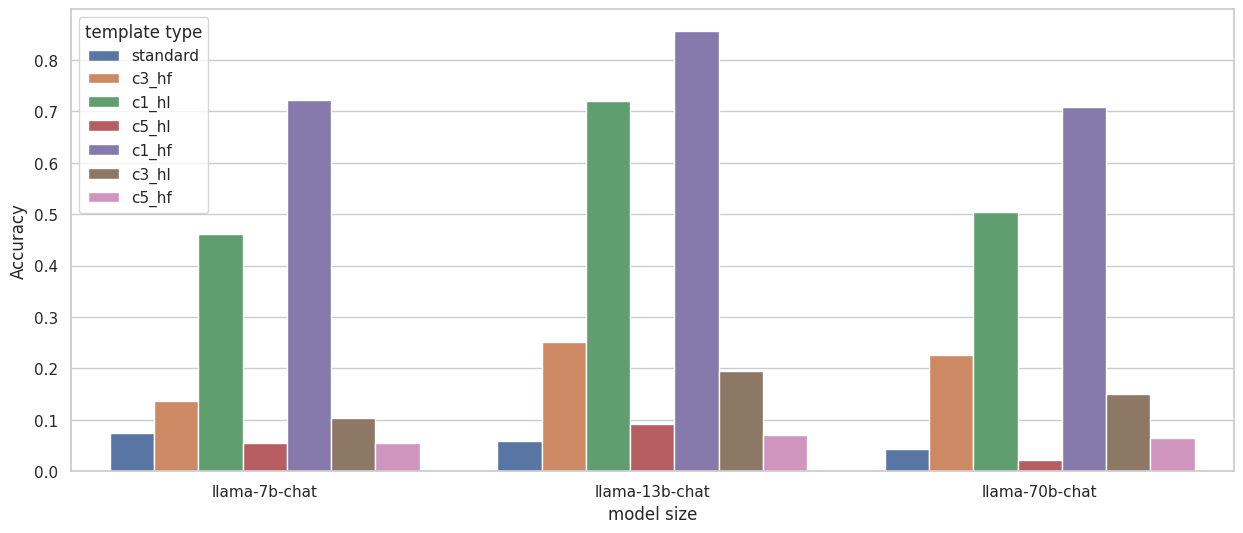

In [27]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

df = pd.DataFrame({'name': names, 'accuracy':accs})

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['name'].apply(add_template_type)
df['model size'] = df['name'].apply(add_model_size)
plt.figure(figsize=(15,6))
sns.barplot(df, x='model size', y='accuracy', hue='template type')
plt.ylabel('Accuracy')

plt.show()


## classifier on semantic embeddings

### load embeddings

In [36]:
dataset_paths = glob('outputs/exp6*/response_encodings.pkl')


datasets_xy = []
for p in dataset_paths:
    with open(p, 'rb') as f:
        ds = pickle.load(f)
        print(len(ds[0]))
        datasets_xy.append(ds)



462
462
462
462
462
462
462


In [37]:
import re

names = [re.findall('exp\d+_(.+)/', x)[0] for x in dataset_paths]
names

['70b_c5_hl_partial',
 '70b_c3_hl_partial',
 '70b_full',
 '70b_c3_hf_partial',
 '70b_c1_hf_partial',
 '70b_c5_hf_partial',
 '70b_c1_hl_partial']

In [38]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder


def train_and_report(ds_x, ds_y):

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(ds_y)

    X_train, X_test, y_train, y_test = train_test_split(ds_x, encoded_labels, test_size=0.2)
    
    model = LogisticRegressionCV(max_iter=200, cv=4)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print('accuracy: ', acc)
    return acc


accs = []
for name, ds in zip(names, datasets_xy):
    print(name)
    accs.append(train_and_report(ds[0], ds[1]))
    

70b_c5_hl_partial
accuracy:  0.03225806451612903
70b_c3_hl_partial
accuracy:  0.043010752688172046
70b_full
accuracy:  0.053763440860215055
70b_c3_hf_partial
accuracy:  0.053763440860215055
70b_c1_hf_partial
accuracy:  0.41935483870967744
70b_c5_hf_partial
accuracy:  0.053763440860215055
70b_c1_hl_partial
accuracy:  0.17204301075268819


In [39]:
import pickle

# with open('pred_acc_sbert_7b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

# with open('pred_acc_sbert_13b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

with open('pred_acc_sbert_70b.pkl', 'wb') as f:
    pickle.dump((names, accs), f)


## combine results and visualize

In [42]:
import pickle

with open('pred_acc_sbert_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_sbert_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_sbert_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names = names_7b + names_13b + names_70b
accs = accs_7b + accs_13b + accs_70b



/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

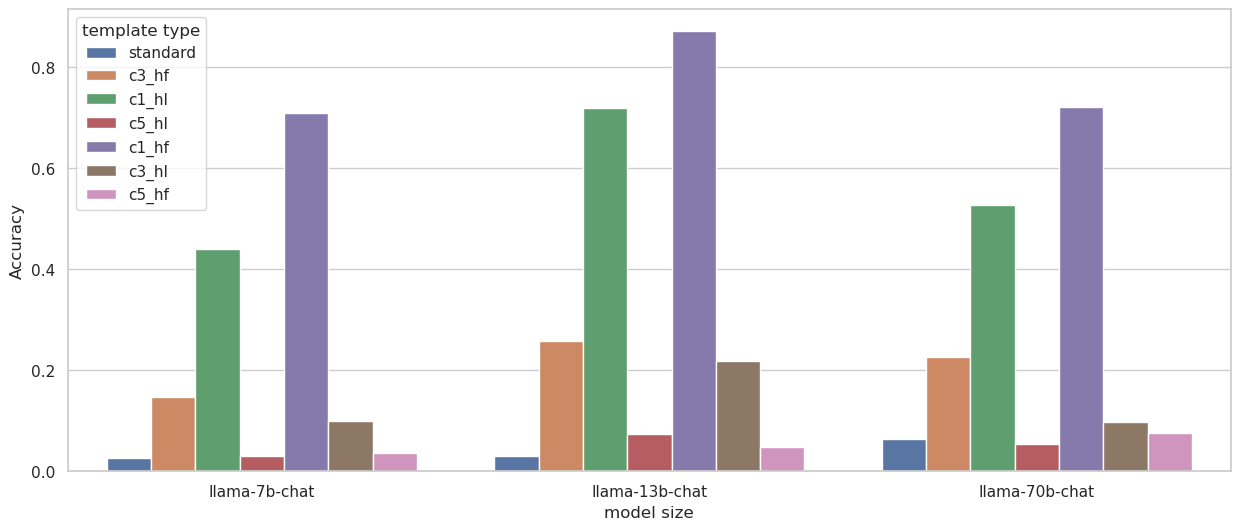

In [43]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

df = pd.DataFrame({'name': names, 'accuracy':accs})

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['name'].apply(add_template_type)
df['model size'] = df['name'].apply(add_model_size)
plt.figure(figsize=(15,6))
sns.barplot(df, x='model size', y='accuracy', hue='template type')
plt.ylabel('Accuracy')

plt.show()


## combined plot for the paper

In [40]:
import pickle

with open('pred_acc_sbert_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_sbert_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_sbert_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names = names_7b + names_13b + names_70b
accs = accs_7b + accs_13b + accs_70b
predictors = ['semantic features']*len(names)

with open('pred_acc_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names += (names_7b + names_13b + names_70b)
accs += (accs_7b + accs_13b + accs_70b)
predictors += ['lexical features']*len((names_7b + names_13b + names_70b))

len(names), len(accs), len(predictors)

(42, 42, 42)

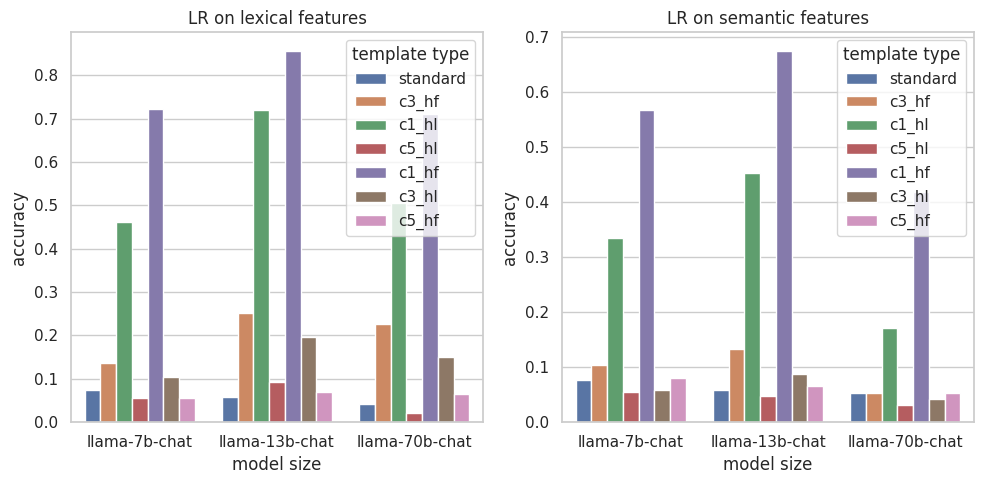

In [41]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

df = pd.DataFrame({'name': names, 'accuracy':accs, 'predictor': predictors})

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['name'].apply(add_template_type)
df['model size'] = df['name'].apply(add_model_size)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data=df[df['predictor']=='lexical features'], x='model size', y='accuracy', hue='template type', ax=axes[0])
axes[0].set_title('LR on lexical features')

sns.barplot(data=df[df['predictor']=='semantic features'], x='model size', y='accuracy', hue='template type', ax=axes[1])
axes[1].set_title('LR on semantic features')

plt.tight_layout()

plt.show()

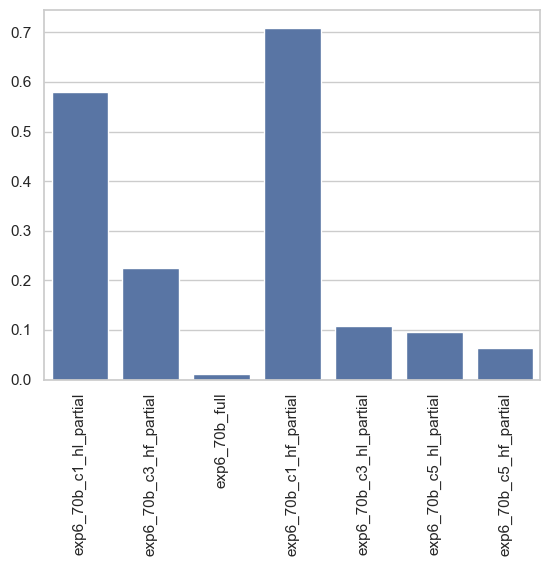

In [11]:
sns.barplot(x=names, y=accs)
plt.xticks(rotation=90)
plt.show()

In [3]:

names = [b.split('/')[-1] for b in bases]
names

['exp5_13b_c1_hf_partial',
 'exp5_13b_c3_hl_partial',
 'exp5_13b_c1_hl_partial',
 'exp5_13b_c3_hf_partial',
 'exp5_13b_full',
 'exp5_13b_c5_hf_partial',
 'exp5_13b_c5_hl_partial']

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk


nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=english_stopwords, lowercase=True, max_df=0.9, ngram_range=(2, 3))

ds_x, ds_y = datasets_xy[0][0], datasets_xy[0][1]

X = vectorizer.fit_transform(ds_x)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(ds_y)

X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2)

model = LogisticRegressionCV(max_iter=300, cv=4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('accuracy: ', acc)

[nltk_data] Downloading package stopwords to /Users/navid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


accuracy:  0.8819188191881919


In [8]:
for i in range(15):
    coefficients = model.coef_[i]
    strategy = label_encoder.inverse_transform([i])[0]
    
    # Step 4: Map coefficients to words
    feature_names = vectorizer.get_feature_names_out()
    word_coefficient_tuples = list(zip(feature_names, coefficients))
    
    # Step 5: Sort and display
    sorted_word_coefficients = sorted(word_coefficient_tuples, key=lambda x: x[1], reverse=True)
    print("*"*100)
    print("strategy: ", strategy)
    print("*"*100)
    for word, score in sorted_word_coefficients[:10]:
        print(f"{word} -> {score}")

****************************************************************************************************
strategy:  Affirmation
****************************************************************************************************
truly commendable -> 2.536004847724735
takes lot -> 1.2970836437147109
shown incredible -> 1.2636371306607148
strength resilience -> 1.146728094224445
resilience facing -> 1.1127727571362704
takes lot courage -> 0.9791329953651547
lot courage -> 0.9753967549290891
incredible resilience -> 0.9448888591869844
good work -> 0.902924186793795
keep good -> 0.902924186793795
****************************************************************************************************
strategy:  Avoid Judgment and Criticism
****************************************************************************************************
important remember -> 2.1460913990083266
okay feel -> 1.7011628739590163
remember everyone -> 1.4240257877329434
important remember everyone -> 1.216943264983963


## semantic based prediction

In [77]:
import pickle

with open("outputs/exp6_70b_full/response_encodings.pkl", 'rb') as f:
    data = pickle.load(f)

data[0].shape

(5, 768)

# analyze the effect of turns on the model performance

In [127]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

ds = list(zip(*datasets_xy[-1]))
ds_train, ds_test = train_test_split(ds, test_size=0.5)

vectorizer = CountVectorizer(stop_words=english_stopwords, lowercase=True, max_df=0.9, ngram_range=(2, 3))


X_train = vectorizer.fit_transform([d[0] for d in ds_train])
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform([d[1] for d in ds_train])


model = LogisticRegression(max_iter=1000)
model.fit(X_train, encoded_labels)

X_test = vectorizer.transform([d[0] for d in ds_test])
y_test = label_encoder.transform([d[1] for d in ds_test])
turns = [d[2] for d in ds_test]

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('accuracy: ', acc)

[nltk_data] Downloading package stopwords to /Users/navid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


accuracy:  0.023668639053254437


<AxesSubplot:>

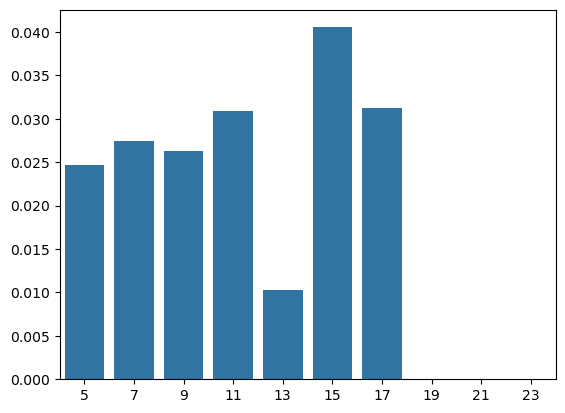

In [132]:
ds_bins = {}

for x, y, turn in ds_test:
    if turn in ds_bins:
        ds_bins[turn].append((x,y))
    else:
        ds_bins[turn] = [(x,y)]


turns = []
accs = []
for turn in ds_bins:

    xs, ys = list(zip(*ds_bins[turn]))
    ys = label_encoder.transform(ys)
    xs = vectorizer.transform(xs)
    y_pred = model.predict(xs)
    acc = accuracy_score(ys, y_pred)
    turns.append(turn)
    accs.append(acc)

sns.barplot(x=turns, y=accs)

# generate continuations of a sample input

In [164]:
import json

with open('test_prompt.json', 'r') as f:
    d = f.read()
    d = json.loads(d)


In [165]:
import sys
sys.path.append('..')

from multiple_strategy_continuation import get_model_and_tokenizer, get_continuation_prompt, convert_to_llama2_chat_partial_conv_format, convert_to_llama2_chat_format


model, tokenizer = get_model_and_tokenizer('nickypro/tinyllama-15M', cache_dir=None, load_in_4bit=False)

generated_conts = get_continuation_prompt(
            d, model, tokenizer,
            get_attentions=False,
            max_new_tokens=512,
            prompt_constructor=convert_to_llama2_chat_format,
            history_first=True,
            n_turns_as_conv=1,
            sample_prob=1.0
        )

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]
No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (256). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


prompt:  <s>[INST] <<SYS>>
You are a helpful and caring friend. Your best friend has come to you with the following situation: "I can't go on a day without having a glass of alcohol". continue the conversation for one turn using "Affirmation" strategy (Description: This involves acknowledging and positively reinforcing an individual's strengths, feelings, or actions. Examples: 'You've shown incredible resilience in facing these challenges.' 'I admire your dedication to improving your situation.' 'Your ability to stay hopeful in tough times is truly commendable.') make your response short and to the point. Do not provide additional info. only respond in one paragraph that satisfies Affirmation strategy. answer in this format: assistant: <response>
<</SYS>>

hello, goodevening [/INST] How are you tonight? </s><s>[INST] I'm feeling unwell, because I've been wanting to stop drinking but here I am with another glass
 Its so hard to stop
 I just to have a day without having any alcohol you k

  7%|███████████▏                                                                                                                                                            | 1/15 [00:02<00:38,  2.76s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Affirmation

response:
"I am three years ago.
The moral of ate. He was so happy. He was the most important. Once upon a lot of a very important less. He was very happy. He was very special. He was the most important person.
The rescue me.
The most.
The end.
The adventures.
The adventure.
Money.
Might.
Mine.
Money.
Money.
Mine.
M missing out the consequences.
M is the consequences.
Money.
Money.
Mine.
M.
Money.
Money.
Money.
Mine.
Money.
Money.
Mine.
Money.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine. Once. Once.
One day.
The future.
M.
Mi't.
One week.
One day.
One week.
.
."
One week.
The challenge.
The help.
The most.
The future.
The future.
One weekend.
The consequences.
The future.
The future.
The future.
Money.
The consequences.
The future.
The consequences.
."
."
The future.
."
."
The consequences. Once.
."
."
."
."
."
."
The future.
."
The consequences. Once.
."
."
."
."
."
."
The most important.
."
."
."
The lessons. Once.
."
."
."
."
."
." Once.
." On

 13%|██████████████████████▍                                                                                                                                                 | 2/15 [00:04<00:30,  2.35s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Avoid Judgment and Criticism

response:
.
Miastic. Hemess. He was the same. Once upon the same. He was the same. He is the most important. He is the most of all the rescue.
The future.
The end.
The adventures.
Mom. He'.
Mine.
Money.
M.
M.
Money.
Money.
M open.
Mi.
Mikey.
Mi.
Money.
Mine.
M.
Mine. It.
Money.
Money.
Money.
M.
Money.
Money.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.




Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine. Once.
Mi.
One day.
One time.
One side.
One day.
One day.
.
Mine.
Mine. Once.
The.
The next.
.
One day.
.
One day.
The.
The consequences.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
."
.
."
."
."
."
."
."
."
."
."
."
." Once. Once.
." Once.
."
."
."
."
."
The consequences.
."
."
."
."
."
."
."
."
."
."
."
." Once.
."
."
."
."
."
."
." Once. Once. Once. Once. Once.
." Once.
." Once.
."
."
."
."
."
."
."
."
"I.
"I.
"I.
"I.
"I.
"I.
"I am.
"Money.
"Money.
Money.
Money.
Money.
Money.
Money.
Mom.
Mommy.
Mom.
Mom.
prompt:  <s>[INST] <<SYS>>
You are a helpful and caring fr

 20%|█████████████████████████████████▌                                                                                                                                      | 3/15 [00:06<00:26,  2.18s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Clarification

response:
"I am: the most important.
Mine. You are the most important to help. You are the most important. You are the same. You are the most important. You are the most of all the rescue from the consequences.
The end.
The challenge to help. You. You. You. You are. You. Once. The day.
M.
Mom. Once upon the same. You will's of the consequences. You. You. You.
The consequences.
The consequences.
The challenge me.
The challengefully.
The challenge.
The next time.
The challenge.
The consequences.
The consequences.
The challenge.
One day.
The consequences.
One minute.
One minute.
The consequences.
The consequences.
The consequences.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
One minute.
"Thank you.
"Thank you's.
"Thank you.
"Thank you's.
The most.
"Dear.
"Dear.
"Dance.
The consequences.
The consequences.
The consequences.
The future.
The future.
The mo

 27%|████████████████████████████████████████████▊                                                                                                                           | 4/15 [00:08<00:23,  2.11s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Collaborative Planning

response:
"I am.
Mom: "I am: I amard. I want to helpers. You will. You will. You are the most important. You are the same. You are the most important.
The end.
Miana. You. You are the most. You. You. You are. You. You. You. You.
Might. Once. He was a lot. He was the number.
M is the number.
M.
M.
Miry.
Mi.
Mom.
Mi.
M.
Money.
Money.
Money.
Mine.
Money.
Mi.
Miastic.
Mi.
Mi.
Mi.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
One day.
One week.
One day.
One weeks.
One week.
Mom.
Mine.
Money.
Mine.
Money.
Money.
Money.
Money.
Mine.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money. Once.
Money.
Mung.
Money.
Money.
Money.
Money.
."
."
."
One day.
."
."
."
."
."
." Once.
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
!"
!"
."
."
"I am.
."
"I am.
"".
"I. I. I. I amows. Iars. I. I. I. I am. I amard. I amal. I am. I am. I am. I. I am. I. I. I. I. I. I.
pro

 33%|████████████████████████████████████████████████████████                                                                                                                | 5/15 [00:10<00:20,  2.08s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Emotional Validation

response:
: the most important to always.
The moral of course. Once upon a little girl. She was very happy. She was a very happy life. He was the most important. He was the most important boy.
The little girl.
The heart.
The help. He is the most.
The end. You. You. You. You. You. You are.
The day.
The day.
The little girl. You are the little girl. You are the number. You are the most. You. You. You are the number. You. You. You. You. You. You. You are the end.
The future.
The future.
The end of the number.
The consequences.
The consequences.
Mi't.
M.
Madders.
Mine.
Mine.
Mine.
M.
Mine.
Mommy.
Mine. Once.
The nights.
Mine.
Mine.
Making time.
M.
M.
Mi.
Madd.
Ms.
M.
Mom've.
Mom.
Mom.
Money.
Ms.
Money.
Money.
Money.
Money.
Ms.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Mine.
Money.
Mom'sise.
Money.
Money.
Money. Once upon the consequences.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
." Once.
." Once.
M.
Money. Once. Once.
."

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 6/15 [00:12<00:18,  2.06s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Normalize Experiences

response:
edient.
The young boy. He was the most important. He was the same. Once upon the same. He was very happy. He was very special. He was the most important.
The rescue me.
The day.
The end.
The adventures. You. You. You. You are. You. You. You. You. You. You are the consequences. You are the consequences. You. You are the consequences of the consequences. You are the best. You are the consequences. You are the consequences. You. You. You. You are. You. You. You.
The consequences.
The consequences.
The consequences.
The consequences.
M.
Mine.
M.
Mine.
Money.
Money.
Mine.
Mi't.
Mine. Once.
Mine.
Money.
Mi.
Mine.
Mine.
Mi.
Mine.
Mi.
Mi.
Mi.
Mine.
Mine.
Mine.
Madd.
Mine.
Money.
Mine.
Mine.
Money.
Mine.
Mi.
Mi.
Money.
Mi.
Mi's.
Money.
Money.
Money.
Madd.
Money.
Money.
Money.
Money.
Money. Once.
Mom.
."
Mom.
Money. Once.
Money.
Money.
Money.
Money.
Mom.
Money.
Money.
Money.
." Once.
." Once.
." Once.
."
."
." Once.
." Once.
."
."
."
." Once.
." Once.

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 7/15 [00:14<00:16,  2.03s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Offer Hope

response:
"I am three years ago.
The moral of ate. He was the most important. Once. He was a lot of the same. He was the most important. He was very happy. He was very special.
The little boy.
The help to help. The help.
The end.
The adventures. You. You. You. You. You. You. Once. You. You. You. You are the little girl. You. You. You are always come with me.
The helpers.
The help.
The end.
The challenge to you.
The challenge. You can's. You. You.
The challenge.
The help.
The challenge. Once.
The challenge.
The challenge.
The end of your heart.
The end.
The challenge. Once.
The end.
The end.
The end.
The future's.
The end. Once. Once.
One day.
One week.
One weekend.
One weekend.
One week.
The help.
One week.
One week.
The challenge.
The help.
The most.
The future.
The future.
The right.
The consequences.
The consequences.
The consequences.
The future.
The consequences.
The consequences.
The future.
The future.
The consequences.
The future.
The consequences.
."
Th

 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 8/15 [00:16<00:14,  2.02s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Promote Self-Care Practices

response:
.
Mine. Heal. He was the most important. Once upon the same. He was the most important boy. He was the most important person. He was the rescue.
The day.
The end.
The adventures.
The adventure.
Mom.
Mine.
Mine.
M.
Mine.
Money.
M open.
Mine.
Money.
Mine.
Mine.
Mine.
Mine.
Mom.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine. Once.
Mine. Once.
Ms.
Making.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
One week.
M."
One weekend.
One week.
The most important.
The weekend.
."
."
."
The to help.
One week.
The week.
."
The future.
."
."
."
The most important.
."
The future.
."
The most important lessons.
."
."
."
."
."
."
." Once.
." Once.
." Once.
."
."
."
."
."
."
." Once.
." Once. Once. Once.
."
." Once.
."
."
."
."
."
. Once.
."
."
."
."
."
."


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 9/15 [00:18<00:12,  2.06s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Provide Different Perspectives

response:
.
Mine. Once upon a little boy. He was very brave. He was always the same. He was a lot of the boy. He was the most important boy.
The boy.
The most of all the rescue.
The future.
The end.
The adventures.
The adventure.
The end.
The day.
The day.
The end.
The future.
The future.
The consequences.
Mine.
Mine.
Mi.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine. Once. Once. Once. Once.
The consequences.
One day.
One day.
One day.
One day.
One day.
One day.
One step.
"Come.
"Come.
The consequences.
The future.
The future.
The endings.
The future.
The future.
The consequences.
The future.
The future.
The future.
The consequences.
The future.
The future.
The consequences.
The most.
."
."
The same.
."
The same.
."
The same. Once.
."
."
."
."
."
."
."
."
."
The same.
."
."
The other ways.
."
."
."
."
The consequences. Once.
." Once.
." Once.
." Once.
." Once.
." O

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 10/15 [00:20<00:10,  2.04s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Reflective Statements

response:
"I am. I am: "I am..."
Mom. I amapyness. You are the most important to help. You are the most important to me. Once upon the same. He is the little girl. He is the best. He. He is the most.
The end.
The adventure.
The news.
Mist.
Mom.
Mine.
M.
Money.
M. You. You are saying. You't. You are the heart. You are the most. You. You are the same.
M.
Mine.
Money.
Mine.
Mine.
Money.
Money.
Money.
Money.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine. Once. Once.
Mine.
Mine.
Mine.
Mi't.
Mine.
M.
Mine.
Mine.
Mine.
Ms.
Mine.
Mine.
Money.
Mine.
Money.
Money.
Money.
Mine.
Money.
Money.
Money.
Money.
Money.
Money.
Madders.
Mine.
Money.
Money.
Money.
M.
Money.
Money.
Mine.
Money. Once.
Money. Once.
Money.
Mung.
Money.
Money.
Money.
"Money.
."
."
One day.
."
."
."
."
." Once.
Move.
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
"I.
."
."
"I.
"I amends.
"I am.
"I amows. I amphant. I am.
"I amows.
"I amph.
"I am. I am.
Money.
Money.
Mo

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 11/15 [00:23<00:08,  2.06s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Reframe Negative Thoughts

response:
edient.
The little girl. He was the most important. He was the same. Once upon the same. He was the same. He is the most important. He is the most of all the rescue.
The day.
The end.
The adventures.
The adventure.
Mine."
The day.
The day.
M.
Money.
Mine. You. You are. You are. You are the consequences. You. You are the consequences.
M.
Mine.
M.
Money.
Money.
Money.
M.
M.
Money.
Money.
Madd.
Maddie.
Mine.
Madd.
Madders.
Mine.
Madders.
Madd.
Madders.
Madd.
Madd.
Madders.
Madders.
Mine.
Madders.
Madders.
One weekend.
Madd.
Madd.
Madders.
Madders.
M.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money. Once.
."
Money.
."
Money.
Money.
Money.
Money.
Money.
Money.
Money.
."
Money.
."
Money.
." Once.
." Once.
." Once.
."
."
."
." Once.
."
."
."
." Once. Once.
." Once.
."
."
."
." Once.
." Once.
."
."
."
."
."
"Lure.
"I and you.
"I.
."
"I amends.
"Money.
"Muc

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 12/15 [00:25<00:06,  2.05s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Share Information

response:
. Once upon the day, a little boy, was very excited. He was very happy. He was very kind. He was very kind to beef. He was the most important.
The boy. He was very special.
The boy. He is the most Once upon a heart. He is the most. He was the street. He.
The news.
The news.
The day.
The news.
The news.
The news.
M is the news.
M.
Mom.
Mom.
Money.
Mom.
Mine.
M.
Money.
Money.
Money.
M.
Money.
Money.
Money.
Money.
M.
Madders.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Money.
Mi.
Mine.
Mine.
Madders.
Ms.
M.
M.
Mine.
Mine.
Money.
Money.
Money.
Money.
Mine.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money. Once.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
."
."
."
." Once.
." Once.
." Once.
." Once.
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
."
"M.
"M.
"I.
Mom.
Mom.
Mom.
Mom.
Money.
Money.
Mom.
Money.
Money.
Money.
Mone

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 13/15 [00:27<00:04,  2.06s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Stress Management

response:
.
The moral of the moral of being so happy. Once upon the little boy was a very brave boy. He was very brave. He was very brave. He was the most important.
The boy. He was the best. He is the boy.
The end.
The challenge.
The challenge.
The challenge.
The challenge. You to challenge. You. You.
The challenge.
Mine.
The challenge.
Money.
Maddie.
Maddy attitude.
Maddy ways to helpers.
Mi.
Mi.
Mine.
M.
Mine.
Mine.
Money.
Mine.
M.
Mine.
Mine.
Madders.
Mi.
Mine.
Mine.
Mine.
Mine.
Madders.
Mine.
Mine.
Madders. Once.
Mine.
Mine.
Mine.
Mine. Once.
M.
Madders.
One day.
One week.
One day.
One day.
One week.
The help.
Mine.
Ms.
Ms.
One day.
Madders.
Madd.
Madd.
Madders.
Money.
Money.
."
."
."
Money.
."
."
Money.
Money.
Mead.
."
."
."
Money.
Money.
."
Money.
."
."
Money.
Money.
."
Money.
Money.
Money.
Money.
."
Money.
Money.
."
."
." Once.
." Once.
." Once.
Money.
." Once.
."
."
."
."
."
."
."
."
."
."
."
."
."
.
."
"Can.
"I am.
."
."
"I.
"I.
Money.
Money.
Mo

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 14/15 [00:29<00:02,  2.05s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




strategy:
Suggest Options

response:
.
The moral of the moral of being so happy. Once upon the little girl was a very brave girl. She was very brave. She was the most important. He was the most important.
The girl. He was so happy. He is the girl.
The heart.
The rescue.
The day.
The end.
The adventures.
The adventure.
The end.
The day.
The day ago.
The day.
The consequences.
The consequences.
The consequences.
The consequences.
The consequences.
The consequences.
The consequences.
Mine.
M.
Mine.
M.
Mine.
Mine.
Money.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine. Once.
Mine.
Mine.
M.
Mine.
M.
M.
M.
M.
Mi's.
M.
Ms.
M.
Mom.
Mine.
Mine.
Ms.
Ms.
Money.
Mine.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money. Once.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Money. Once.
Money.
Money.
." Once.
Money.
."
."
." Once.
." Once.
." Once.
."
."
."
." Once.
."
."
."
."
." Once. Once.
." Once.
."
."
."
One day.
"M.
"I.
"I

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.08s/it]



strategy:
Chit Chat

response:
.
The moral of the moral of being so happy. Once upon a little boy was a very brave boy. He was very brave. He was very brave. He was the most important.
The boy. He was the best. He is the boy.
The most importantness.
The help.
The next.
The end of the journey.
The family.
The news.
The day.
The day.
The day.
The most.
The little girl. You. You are the heart. You are the heart. You. You are the consequences. You are always.
The challenge.
The challenge.
The challenge.
The challenge.
Making.
Making.
Mine.
Making.
Making.
Making.
Making.
Madders.
Making.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Madd.
Mine.
Mine.
Ms.
Mine.
Mine.
Mine.
Mee.
Mine.
Money.
Money.
Money.
Money.
Mine.
Mine.
Money.
Money.
Money.
Money.
Money.
Money.
Money.
Mine.
Money.
Mine.
Money.
Money.
Mine.
Money.
Money.
Money.
Money.
Money.
Mine.
Money.
Money.
Mine.
Money.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine.
Mine. Once.
Mine.
Mine.
Mine.
Mine.
Money. Once.
Money.
Mo

# compare layer restricted attentions

In [14]:
from glob import glob

files = glob('outputs/exp12*/*.pkl')
print(files)


['outputs/exp12_7b/555_all.pkl', 'outputs/exp12_7b/1277_all.pkl', 'outputs/exp12_7b/579_all.pkl', 'outputs/exp12_7b/2386_all.pkl', 'outputs/exp12_7b/782_all.pkl', 'outputs/exp12_7b/1128_all.pkl', 'outputs/exp12_7b/959_all.pkl', 'outputs/exp12_7b/81_all.pkl', 'outputs/exp12_7b/3263_all.pkl', 'outputs/exp12_7b/83_all.pkl', 'outputs/exp12_70b/555_all.pkl', 'outputs/exp12_70b/1277_all.pkl', 'outputs/exp12_70b/579_all.pkl', 'outputs/exp12_70b/2386_all.pkl', 'outputs/exp12_70b/782_all.pkl', 'outputs/exp12_70b/1128_all.pkl', 'outputs/exp12_70b/959_all.pkl', 'outputs/exp12_70b/81_all.pkl', 'outputs/exp12_70b/3263_all.pkl', 'outputs/exp12_70b/83_all.pkl', 'outputs/exp12_13b/555_all.pkl', 'outputs/exp12_13b/1277_all.pkl', 'outputs/exp12_13b/579_all.pkl', 'outputs/exp12_13b/2386_all.pkl', 'outputs/exp12_13b/782_all.pkl', 'outputs/exp12_13b/1128_all.pkl', 'outputs/exp12_13b/959_all.pkl', 'outputs/exp12_13b/81_all.pkl', 'outputs/exp12_13b/3263_all.pkl', 'outputs/exp12_13b/83_all.pkl']


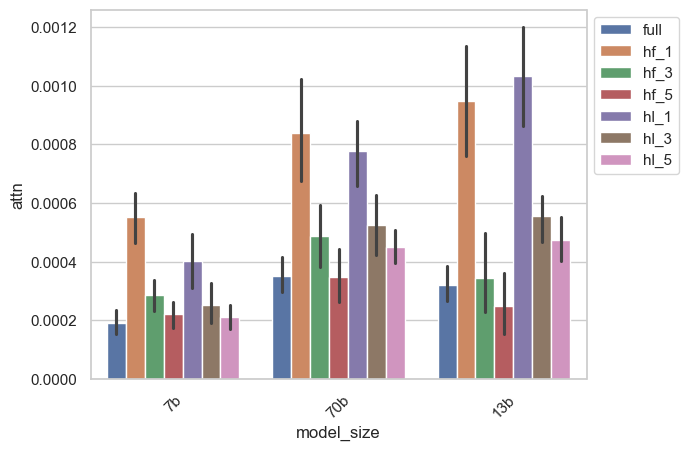

In [16]:
import pickle
import re

df_list = []
for p in files:
    with open(p, 'rb') as f:
        d = pickle.load(f)

    for exp, strategy_attn in d.items():
        if strategy_attn is None:
            continue
        for strategy, (tokens, attentions) in strategy_attn.items():     
            decoded_prompt = tokenizer.decode(tokens, skip_special_tokens=False)
            match = re.findall(f'You are a helpful and caring friend.+{strategy} strategy\.', decoded_prompt)
            if len(match) == 0 or len(match) > 1:
                print("WARNING: zero or multiple matches. continuing..")
                continue
            attn = get_average_attention_over_sequence(attentions, tokens, sequence=match[0], tokenizer=tokenizer)
            df_list.append({
                'strategy': strategy,
                'exp': exp,
                'attn':attn,
                'path': p
            })


def add_layer_size(value):
    return re.findall('l\d+', value)[0]

def add_model_size(value):
    return re.findall('\d+b', value)[0]

def add_template_type(value):
    return re.findall('full|hf_\d+|hl_\d+', value)[0]

df = pd.DataFrame(df_list)

df['template'] = df['exp'].apply(add_template_type)
df['model_size'] = df['path'].apply(add_model_size)
df['attn_layers'] = df['exp'].apply(add_layer_size)
sns.barplot(df[df['attn_layers']=='l10'], x='model_size', y='attn', hue='template')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [271]:
df['attn_layers'].unique()

array(['l1', 'l5', 'l10', 'l20'], dtype=object)

#